In [1]:
from cobra.io import read_sbml_model
from cobra import Reaction
from cobra.flux_analysis.phenotype_phase_plane import production_envelope
from cobra.flux_analysis import moma
import numpy as np

model = read_sbml_model('iML1515.xml')

# Check genes

In [2]:
genes = ["b0677", "b0678", "b0679", "b1817", "b1818", "b1819", "b1101", "b2415", "b2416", "b2417"]
essentiality = {}
for gene in genes:
    with model:
        model.genes.get_by_id(gene).knock_out()
        essentiality[gene] = model.slim_optimize(error_value=0.)

In [3]:
essentiality

{'b0677': 0.8769972144269641,
 'b0678': 0.876997214426954,
 'b0679': 0.876997214426954,
 'b1817': 0.876997214426954,
 'b1818': 0.876997214426954,
 'b1819': 0.876997214426954,
 'b1101': 0.876997214426954,
 'b2415': 0.8675930236571694,
 'b2416': 0.8675930236571694,
 'b2417': 0.8769972144269657}

<AxesSubplot: ylabel='Frequency'>

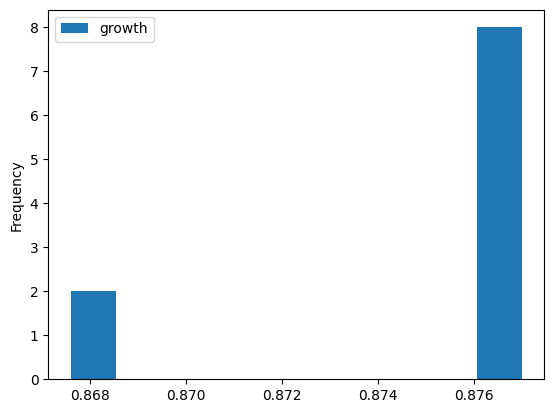

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame.from_dict(essentiality, orient='index')
df = df.rename(columns={0: 'growth'})
df = df.sort_values('growth')
df.plot.hist()

22.823896531250035
22.823896531250035
0.45
22.823896531249527
22.823896531249527
0.45


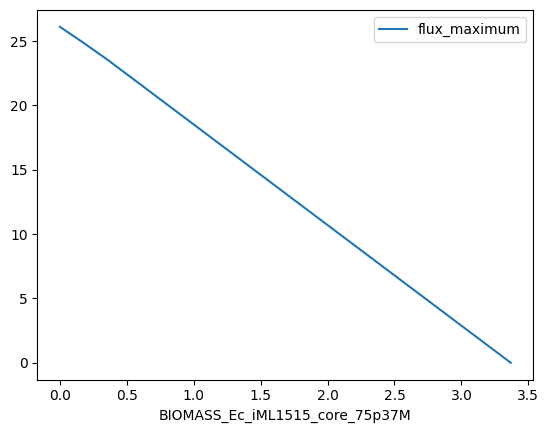

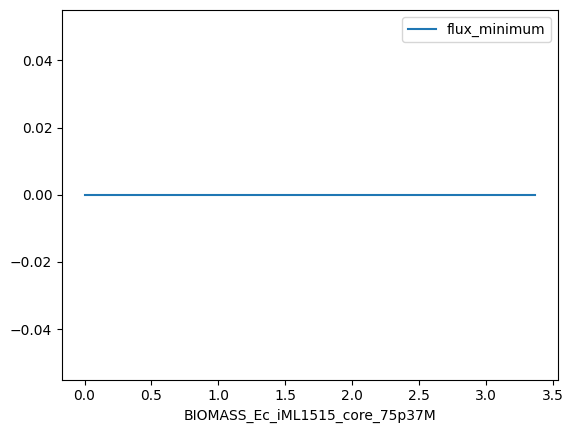

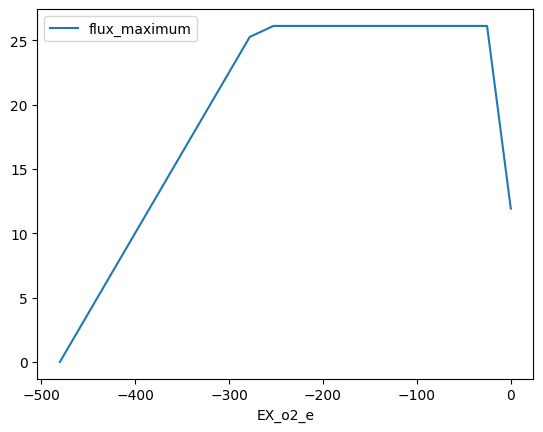

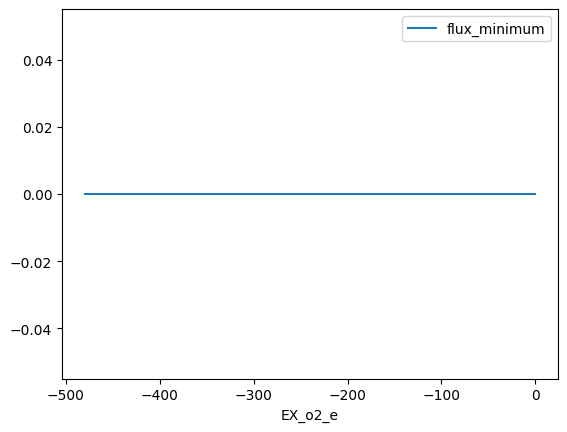

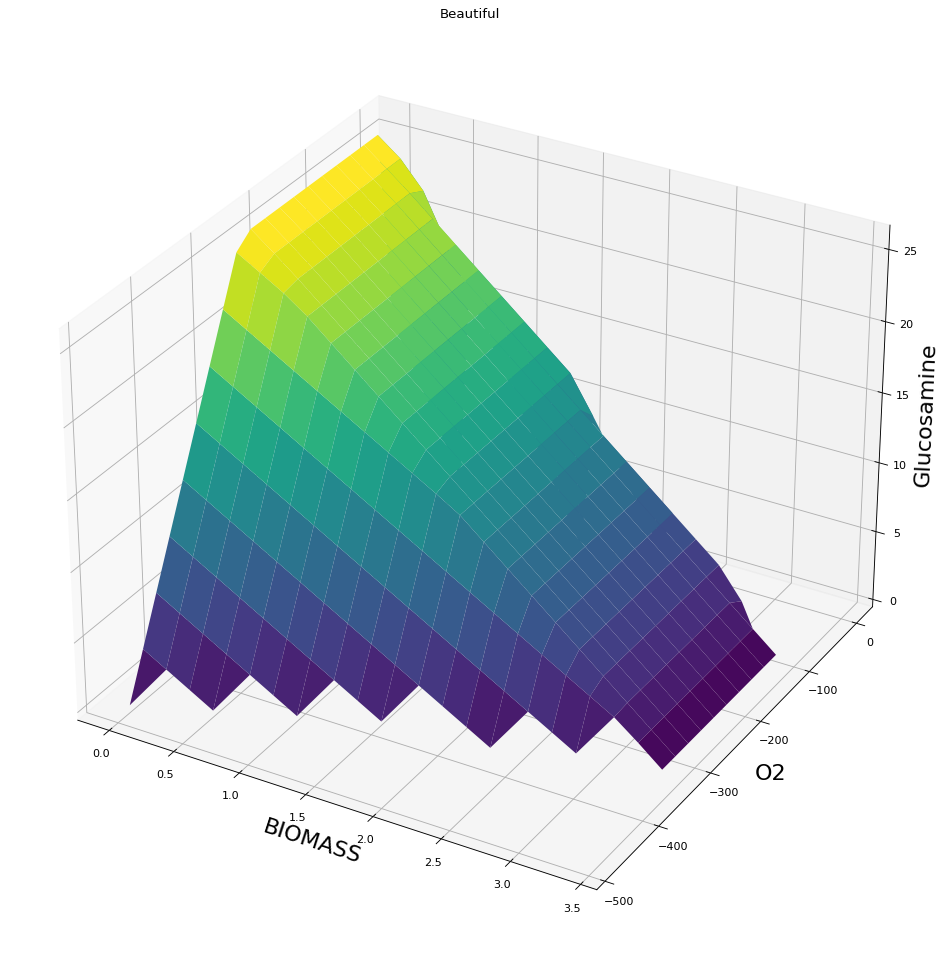

In [5]:
medium = model.medium
with model:
    # media
    medium['EX_glc__D_e'] = 30
    medium['EX_rib__D_e'] = 10
    medium['EX_chtbs_e'] = 0
    model.medium = medium
    
    # gene knockout
    model.genes.get_by_id("b0677").knock_out()
    model.genes.get_by_id("b0678").knock_out()
    model.genes.get_by_id("b0679").knock_out()
    model.genes.get_by_id("b1817").knock_out()
    model.genes.get_by_id("b1818").knock_out()
    model.genes.get_by_id("b1819").knock_out()
    model.genes.get_by_id("b1101").knock_out()
    model.genes.get_by_id("b2415").knock_out()
    model.genes.get_by_id("b2416").knock_out()
    model.genes.get_by_id("b2417").knock_out()
    
    # gene integration
    reaction = Reaction("ExRe1")
    reaction.name = "GlcNAc-6-P N-Acetyltransferase"
    reaction.lower_bound = 0
    reaction.upper_bound = 1000

    reaction.add_metabolites({
        model.metabolites.get_by_id("accoa_c"): -1.0,
        model.metabolites.get_by_id("gam6p_c"): -1.0,
        model.metabolites.get_by_id("acgam6p_c"): 1.0,
        model.metabolites.get_by_id("coa_c"): 1.0,
        model.metabolites.get_by_id("h_c"): 1.0,
    })
    model.add_reactions([reaction])
    reaction = Reaction("ExRe2")
    reaction.name = "GlcNAc-6-P phosphatase"
    reaction.lower_bound = 0
    reaction.upper_bound = 1000

    reaction.add_metabolites({
        model.metabolites.get_by_id("acgam6p_c"): -1.0,
        model.metabolites.get_by_id("h2o_p"): -1.0,
        model.metabolites.get_by_id("pi_p"): 1.0,
        model.metabolites.get_by_id("acgam_p"): 1.0
    })
    model.add_reactions([reaction])

    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.45
    model.objective = model.reactions.ExRe2
    solution = model.optimize()

    print(solution.fluxes["ExRe1"])
    print(solution.fluxes["ExRe2"])   
    print(solution.fluxes["BIOMASS_Ec_iML1515_core_75p37M"])
    
    moma_res = moma(model, solution)
    print(moma_res.fluxes["ExRe1"])
    print(moma_res.fluxes["ExRe2"])   
    print(moma_res.fluxes["BIOMASS_Ec_iML1515_core_75p37M"])
    
    model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0
    
    # PPP
    growth = production_envelope(model, reactions=model.reactions.BIOMASS_Ec_iML1515_core_75p37M, 
                               objective=model.reactions.ExRe2)
    growth.plot(x='BIOMASS_Ec_iML1515_core_75p37M', y='flux_maximum')
    growth.plot(x="BIOMASS_Ec_iML1515_core_75p37M", y= "flux_minimum")  
    
    oxy = production_envelope(model, reactions=model.reactions.EX_o2_e, 
                               objective=model.reactions.ExRe2)
    oxy.plot(x='EX_o2_e', y='flux_maximum')
    oxy.plot(x="EX_o2_e", y= "flux_minimum")  
    
    result_3D = production_envelope(model, reactions=[model.reactions.BIOMASS_Ec_iML1515_core_75p37M, model.reactions.EX_o2_e],
                                   objective=model.reactions.ExRe2)
    fig = plt.figure(figsize=(15, 15), dpi=80)
    ax = plt.axes(projection='3d')
    ax.plot_surface(np.reshape(np.asarray(result_3D.BIOMASS_Ec_iML1515_core_75p37M), (-1, 20)), 
                    np.reshape(np.asarray(result_3D.EX_o2_e), (-1, 20)), 
                    np.reshape(np.asarray(result_3D.flux_maximum), (-1, 20)),
                    rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_title('Beautiful')
    ax.set_xlabel('BIOMASS', fontsize=20, rotation = 0)
    ax.set_ylabel('O2', fontsize=20, rotation = 0)
    ax.set_zlabel('Glucosamine', fontsize=20, rotation = 0)

# FVA

In [10]:
from cameo import flux_variability_analysis as flux_vari_analysis
from cameo.visualization.plotting.with_plotly import PlotlyPlotter
import warnings
warnings.filterwarnings("ignore")

plotter = PlotlyPlotter()

In [7]:
# media
medium = model.medium
medium['EX_glc__D_e'] = 30
medium['EX_rib__D_e'] = 10
model.medium = medium

model.genes.get_by_id("b0677").knock_out()
model.genes.get_by_id("b0678").knock_out()
model.genes.get_by_id("b0679").knock_out()
model.genes.get_by_id("b1817").knock_out()
model.genes.get_by_id("b1818").knock_out()
model.genes.get_by_id("b1819").knock_out()
model.genes.get_by_id("b1101").knock_out()
model.genes.get_by_id("b2415").knock_out()
model.genes.get_by_id("b2416").knock_out()
model.genes.get_by_id("b2417").knock_out()

#gene integration
reaction = Reaction("ExRe1")
reaction.name = "GlcNAc-6-P N-Acetyltransferase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("ac_c"): -1.0,
    model.metabolites.get_by_id("gam6p_c"): -1.0,
    model.metabolites.get_by_id("acgam6p_c"): 1.0,
    model.metabolites.get_by_id("h2o_c"): 1.0
})
model.add_reactions([reaction])
reaction = Reaction("ExRe2")
reaction.name = "GlcNAc-6-P phosphatase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("acgam6p_c"): -1.0,
    model.metabolites.get_by_id("pyr_c"): -1.0,
    model.metabolites.get_by_id("pep_c"): 1.0,
    model.metabolites.get_by_id("acgam_p"): 1.0
})
model.add_reactions([reaction])



In [8]:
fva_result = flux_vari_analysis(model)

In [11]:
fva_result.plot(plotter, 
                index=fva_result.data_frame.index[2700:2714]
               )

B:\anaconda3\envs\cell_factory_design\lib\site-packages\cameo\flux_analysis\analysis.py:895: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

B:\anaconda3\envs\cell_factory_design\lib\site-packages\cameo\flux_analysis\analysis.py:895: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

B:\anaconda3\envs\cell_factory_design\lib\site-packages\cameo\flux_analysis\analysis.py:895: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

B:\anaconda3\envs\cell_factory_design\lib\site-packages\cameo\flux_analysis\analysis.py:895: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

B:\anaconda3\envs\cell_factory_design\lib\site-packages\cameo\flux_analysis\analysis.py:

In [12]:
fva_result2 = flux_vari_analysis(model,fraction_of_optimum=0.95)

In [13]:
fva_result2.plot(plotter, index=fva_result.data_frame.index[2700:2714])

B:\anaconda3\envs\cell_factory_design\lib\site-packages\cameo\flux_analysis\analysis.py:895: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

B:\anaconda3\envs\cell_factory_design\lib\site-packages\cameo\flux_analysis\analysis.py:895: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

B:\anaconda3\envs\cell_factory_design\lib\site-packages\cameo\flux_analysis\analysis.py:895: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

B:\anaconda3\envs\cell_factory_design\lib\site-packages\cameo\flux_analysis\analysis.py:895: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

B:\anaconda3\envs\cell_factory_design\lib\site-packages\cameo\flux_analysis\analysis.py:

### Downregulate

In [14]:
a = fva_result2.data_frame["lower_bound"] - fva_result.data_frame["upper_bound"]

In [15]:
a[a > 0]

DBTS         0.000004
DM_amob_c    0.000002
MOBDabcpp    0.000003
MOBDtex      0.000003
AMAOTr       0.000002
MALCOAMT     0.000003
OGMEACPS     0.000001
OGMEACPR     0.000001
OPMEACPS     0.000001
AOXSr2       0.000005
dtype: float64

### Upregulate

In [16]:
b = fva_result2.data_frame["upper_bound"] - fva_result.data_frame["lower_bound"]

In [17]:
b[b < 0]

EX_mobd_e   -4.924759e-07
MEOHtrpp    -4.063434e-07
MEOHtex     -5.550844e-06
dtype: float64

In [65]:
with model:
    model.objective = "EX_acgam_e"
    optimum=model.optimize().objective_value
    i=1
    FVA=flux_variability_analysis(model,model.reactions.EX_glc__D_e,fraction_of_optimum=i)
    Biomass.append(FVA.maximum.item())
    print(FVA.maximum.item())

-30.00000000000008


In [88]:
from cobra.flux_analysis import flux_variability_analysis
x=[]
y=[]
z=[]
k=[]
m=[]
Biomass=[]
Productivity1=[]
Productivity2=[]
Glucosamine=[]
optimum_value=[]
with model:
    model.objective = "EX_acgam_e"
    optimum=model.optimize().objective_value
    i=0.05
    while i<1:
        FVA=flux_variability_analysis(model,model.reactions.BIOMASS_Ec_iML1515_core_75p37M,fraction_of_optimum=i)
        Biomass.append(FVA.maximum.item())
        Productivity1.append(-i*optimum*FVA.maximum.item()/model.optimize().fluxes['EX_glc__D_e'])
        Productivity2.append(-i*optimum*FVA.maximum.item()/model.optimize().fluxes['EX_rib__D_e'])
#         Productivity1.append(i*optimum*FVA.maximum.item())
#         Productivity2.append(i*optimum*FVA.maximum.item())
        Glucosamine.append(i*optimum)
        optimum_value.append(i)
        i+=0.05 
    x.append(Biomass)
    y.append(Productivity1)
    z.append(Glucosamine)
    k.append(optimum_value)
    m.append(Productivity2)

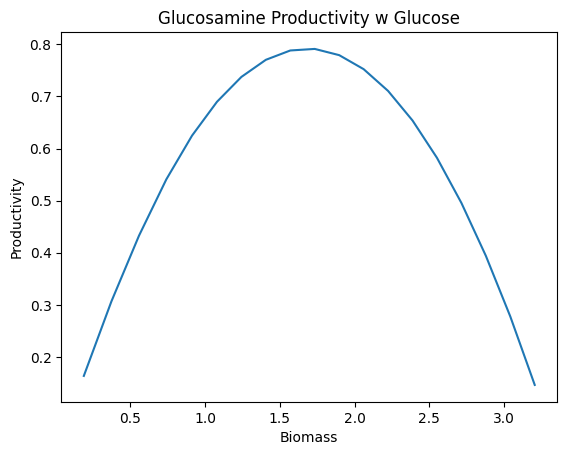

In [89]:
import matplotlib.pyplot as plt
for i in range (0,len(y)):
    plt.figure()
    plt.plot(x[i],y[i])
    plt.xlabel("Biomass")
    plt.ylabel("Productivity")
    plt.title('Glucosamine Productivity w Glucose') 
plt.show()

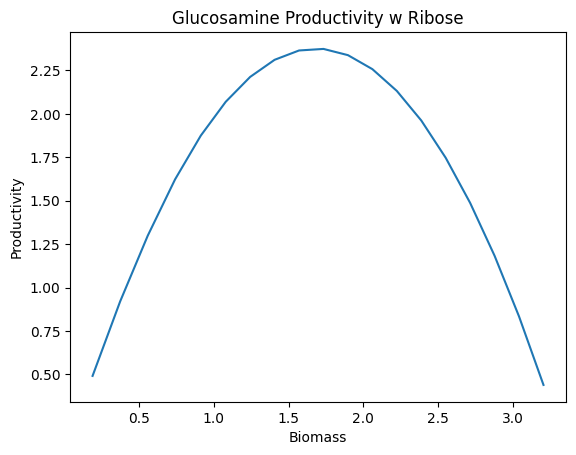

In [90]:
import matplotlib.pyplot as plt
for i in range (0,len(y)):
    plt.figure()
    plt.plot(x[i],m[i])
    plt.xlabel("Biomass")
    plt.ylabel("Productivity")
    plt.title('Glucosamine Productivity w Ribose') 
plt.show()

In [91]:
a=np.concatenate((np.asanyarray(x).flatten(),np.asanyarray(x).flatten()))

In [92]:
a=a.reshape(-1,19)

In [93]:
b=np.concatenate((np.asanyarray(m).flatten(),np.asanyarray(y).flatten()))
b=b.reshape(-1,19)

In [94]:
c=np.concatenate((np.asanyarray(y).flatten(),np.asanyarray(y).flatten()))
c=c.reshape(-1,19)

Text(0.5, 0, 'Growth')

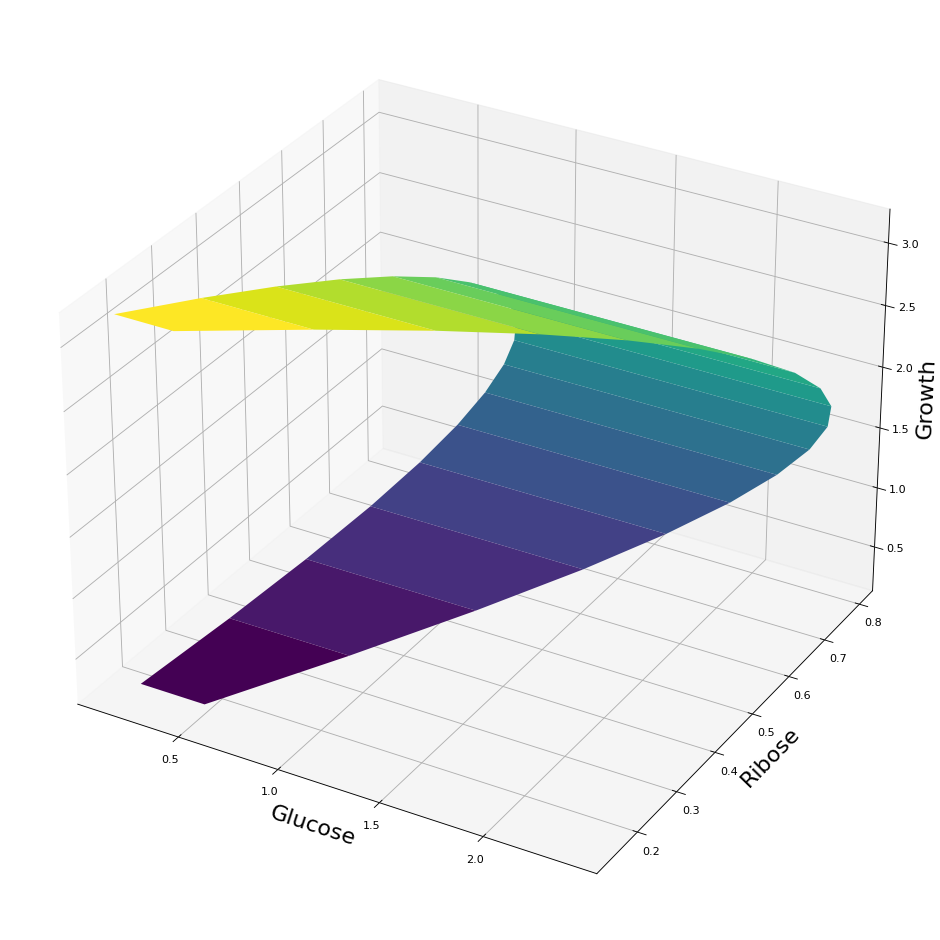

In [95]:
fig = plt.figure(figsize=(15, 15), dpi=80)
ax = plt.axes(projection='3d')
ax.plot_surface(b,c,a,
                rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('Glucose', fontsize=20, rotation = 0)
ax.set_ylabel('Ribose', fontsize=20, rotation = 0)
ax.set_zlabel('Growth', fontsize=20, rotation = 0)

In [96]:
Biomass_sorted,Productivity1_sorted,Productivity2_sorted,GLSsorted,optimum_value_sorted = zip(*sorted(list(zip(Biomass, Productivity1,Productivity2,Glucosamine,optimum_value)), key=lambda item: item[1], reverse=True))
print("The highest productivity will be reached when:")
print("growth rate is ", Biomass_sorted[1], "/h,") # Higer than literature value
print("and the corresponding productivity will be", Productivity1_sorted[1], "mol/mol/h")
print("and the corresponding productivity will be", Productivity2_sorted[1], "mol/mol/h")
print("The Glucosamine production rate will be",GLSsorted[1], "mmol/gdcw/h." )
print("The optimum value set for production of Glucosamine is",  optimum_value_sorted[1])

The highest productivity will be reached when:
growth rate is  1.570124944815242 /h,
and the corresponding productivity will be 0.7883422889590148 mol/mol/h
and the corresponding productivity will be 2.365026866877044 mol/mol/h
The Glucosamine production rate will be 15.062666666666704 mmol/gdcw/h.
The optimum value set for production of Glucosamine is 0.5499999999999999


In [97]:
Biomass_sorted,Productivity1_sorted,Productivity2_sorted,GLSsorted,optimum_value_sorted = zip(*sorted(list(zip(Biomass, Productivity1,Productivity2,Glucosamine,optimum_value)), key=lambda item: item[2], reverse=True))
print("The highest productivity will be reached when:")
print("growth rate is ", Biomass_sorted[1], "/h,") # Higer than literature value
print("and the corresponding productivity will be", Productivity1_sorted[1], "mol/mol/h")
print("and the corresponding productivity will be", Productivity2_sorted[1], "mol/mol/h")
print("The Glucosamine production rate will be",GLSsorted[1], "mmol/gdcw/h." )
print("The optimum value set for production of Glucosamine is",  optimum_value_sorted[1])

The highest productivity will be reached when:
growth rate is  1.570124944815242 /h,
and the corresponding productivity will be 0.7883422889590148 mol/mol/h
and the corresponding productivity will be 2.365026866877044 mol/mol/h
The Glucosamine production rate will be 15.062666666666704 mmol/gdcw/h.
The optimum value set for production of Glucosamine is 0.5499999999999999


## Overexpression

In [98]:
model_growth = model.copy()

In [99]:
model_growth.objective = "BIOMASS_Ec_iML1515_core_75p37M"
model.objective = "ExRe2"
model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.45 # Paper reference

In [100]:
model.reactions.GF6PTA

<Reaction GF6PTA at 0x1badaa988b0>

In [102]:
print("Compare the optimum flux with original model optimised only for cell growth, the expression levels are increased as follows:")
print("For Glutamine-fructose-6-phosphate transaminase: the flux increased from", model_growth.optimize().fluxes['GF6PTA'], "to", model.optimize().fluxes['GF6PTA'])

print("For Glutamine-fructose-6-phosphate transaminase, flux increased by:" , (model.optimize().fluxes['GF6PTA'] - model_growth.optimize().fluxes['GF6PTA'])/model_growth.optimize().fluxes['GF6PTA'] * 100, "%")

Compare the optimum flux with original model optimised only for cell growth, the expression levels are increased as follows:
For Glutamine-fructose-6-phosphate transaminase: the flux increased from 0.3183402548224383 to 24.12030031560647
For Glutamine-fructose-6-phosphate transaminase, flux increased by: 7476.892947158108 %


In [576]:
model = read_sbml_model('iML1515.xml')  

## Using networkx to analyze the network

In [103]:
model.reactions.PGAMT

<Reaction PGAMT at 0x1bada884eb0>

In [502]:
#set the bounds of SQLS
model.reactions.get_by_id('GF6PTA').bounds = (24.12030031560728,24.12030031560728)
print("The optimal fluxes of the reaction corresponding to the overexpression genes are:")
print("For Squalene synthase: ", model.optimize().fluxes['GF6PTA'])

The optimal fluxes of the reaction corresponding to the overexpression genes are:
For Squalene synthase:  24.12030031560728


In [ ]:
#To compare with model optimised for cell growth
model_growth=read_sbml_model('iJN678mod.xml')  
model_growth.objective = "BIOMASS_Ec_SynAuto"

In [178]:
model = read_sbml_model('iML1515.xml')

In [179]:
# media
medium = model.medium
medium['EX_glc__D_e'] = 30
medium['EX_rib__D_e'] = 10
model.medium = medium

model.genes.get_by_id("b0677").knock_out()
model.genes.get_by_id("b0678").knock_out()
model.genes.get_by_id("b0679").knock_out()
model.genes.get_by_id("b1817").knock_out()
model.genes.get_by_id("b1818").knock_out()
model.genes.get_by_id("b1819").knock_out()
model.genes.get_by_id("b1101").knock_out()
model.genes.get_by_id("b2415").knock_out()
model.genes.get_by_id("b2416").knock_out()
model.genes.get_by_id("b2417").knock_out()

#gene integration
reaction = Reaction("ExRe1")
reaction.name = "GlcNAc-6-P N-Acetyltransferase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("ac_c"): -1.0,
    model.metabolites.get_by_id("gam6p_c"): -1.0,
    model.metabolites.get_by_id("acgam6p_c"): 1.0,
    model.metabolites.get_by_id("h2o_c"): 1.0
})
model.add_reactions([reaction])
reaction = Reaction("ExRe2")
reaction.name = "GlcNAc-6-P phosphatase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("acgam6p_c"): -1.0,
    model.metabolites.get_by_id("pyr_c"): -1.0,
    model.metabolites.get_by_id("pep_c"): 1.0,
    model.metabolites.get_by_id("acgam_p"): 1.0
})
model.add_reactions([reaction])

model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.45

In [139]:
from cobra.util import create_stoichiometric_matrix
S = create_stoichiometric_matrix(model)

In [140]:
S

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [141]:
import numpy as np
S_hat = np.where(S==0, S, 1)
A_v = S_hat.T @ S_hat
A_x = S_hat @ S_hat.T

In [142]:
import networkx as nx

In [143]:
compound_centric_network = nx.from_numpy_matrix(A_x)

In [144]:
mapping = dict(zip(range(0, len(model.metabolites)), model.metabolites))
compound_centric_network = nx.relabel_nodes(compound_centric_network, mapping)

In [145]:
metabolite_degrees = compound_centric_network.degree()

In [146]:
sorted_metabolite_degrees = sorted(metabolite_degrees, key=lambda item: item[1], reverse=True)
sorted_metabolite_degrees[0:10]

[(<Metabolite h_c at 0x1baed134c40>, 1216),
 (<Metabolite h2o_c at 0x1baecfd95e0>, 864),
 (<Metabolite atp_c at 0x1baed1a25b0>, 610),
 (<Metabolite pi_c at 0x1baeda265b0>, 557),
 (<Metabolite adp_c at 0x1baee38f700>, 525),
 (<Metabolite h_p at 0x1baeda8a100>, 479),
 (<Metabolite ppi_c at 0x1baeeef2160>, 302),
 (<Metabolite nad_c at 0x1baeda8a1c0>, 298),
 (<Metabolite nadp_c at 0x1baeeef2340>, 294),
 (<Metabolite nadph_c at 0x1baee43a8e0>, 294)]

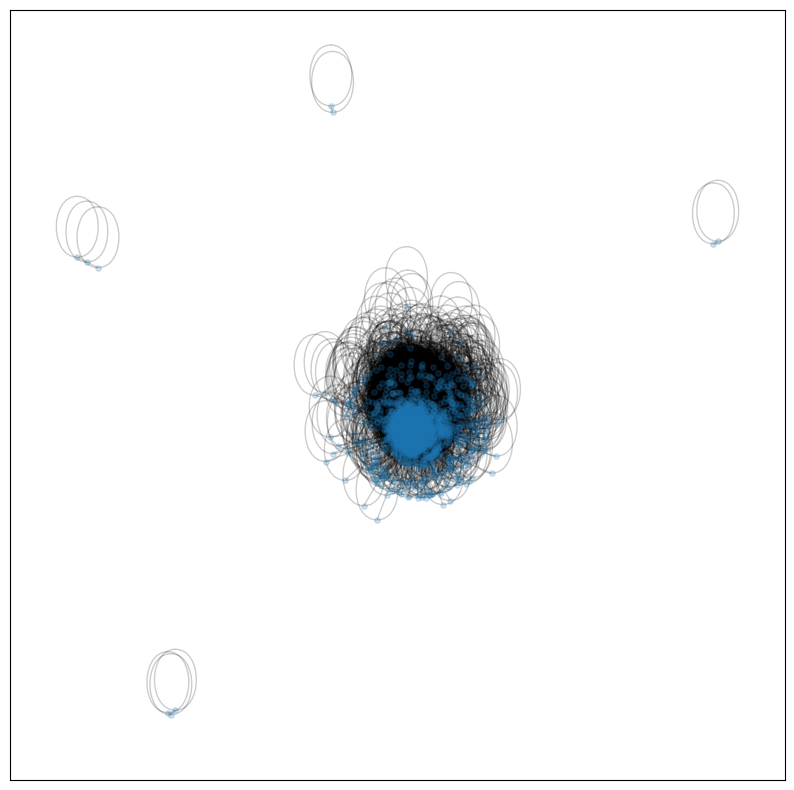

In [147]:
plt.figure(figsize=(10, 10))
nx.draw_networkx(compound_centric_network, node_size=15, alpha=.2, with_labels=False)

In [148]:
a=list(compound_centric_network.nodes)[565]
b=list(compound_centric_network.nodes)[420]
for i in range(len(list(compound_centric_network.nodes))):
    print(i, list(compound_centric_network.nodes)[i])

0 octapb_c
1 cysi__L_e
2 dhap_c
3 prbatp_c
4 10fthf_c
5 btal_c
6 6pgg_c
7 co2_e
8 akg_e
9 gsn_e
10 pydx5p_c
11 3dhgulnp_c
12 g3ps_c
13 adphep_LD_c
14 lyx__L_c
15 din_p
16 2pg_c
17 ptrc_p
18 malt_p
19 pppn_p
20 arbtn_p
21 hphhlipa_c
22 phphhlipa_c
23 13dpg_c
24 murein3px4p_p
25 34dhpac_e
26 1odec11eg3p_c
27 12dgr181_p
28 anhgm_e
29 prbamp_c
30 dsbdrd_c
31 cu2_p
32 sla_c
33 14glucan_p
34 grdp_c
35 ribflv_p
36 dms_e
37 pgp141_c
38 cysi__L_c
39 fpram_c
40 f1p_c
41 dsbard_p
42 thr__L_c
43 dcyt_p
44 2ddglcn_c
45 fum_p
46 galctn__L_e
47 btn_e
48 pydxn_p
49 ocdcea_e
50 preq0_c
51 tyr__L_p
52 dtdp4d6dg_c
53 acmum_e
54 man_p
55 adocbl_e
56 iscu_2fe2s_c
57 frulysp_c
58 dump_p
59 novbcn_e
60 feenter_e
61 eca4und_p
62 gg4abut_c
63 flxr_c
64 pa160_c
65 lcts_c
66 arbtn_e
67 cdpdhdec9eg_c
68 aso3_c
69 progly_c
70 3ohdcoa_c
71 clpn161_p
72 1ddecg3p_p
73 gln__L_e
74 cpgn_un_e
75 ca2_p
76 tre_e
77 iscssh_c
78 glyald_c
79 alaala_e
80 novbcn_p
81 3ohexACP_c
82 g3pg_c
83 rpntp_c
84 adocbl_c
85 3ocddec5eACP_

In [149]:
print(nx.shortest_path(compound_centric_network, source=a, target=b))

[<Metabolite glc__D_c at 0x1baed1abb50>, <Metabolite h_c at 0x1baed134c40>, <Metabolite uacgam_c at 0x1baef4e82e0>, <Metabolite puacgam_c at 0x1baeeef2280>, <Metabolite puacgam_p at 0x1baee38fa30>]


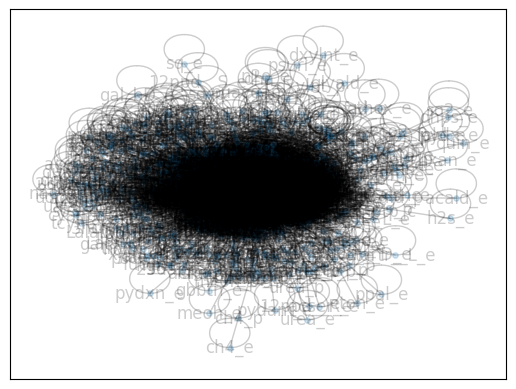

In [150]:
A = (compound_centric_network.subgraph(c) for c in nx.connected_components(compound_centric_network))
A = list(A)[0]
nx.draw_networkx(A, node_size=15, alpha=.2, with_labels=True)

In [151]:
acgam_p = list(compound_centric_network.nodes)[1607]
acgam6p_c = list(compound_centric_network.nodes)[133]
gam6p_c = list(compound_centric_network.nodes)[1443]

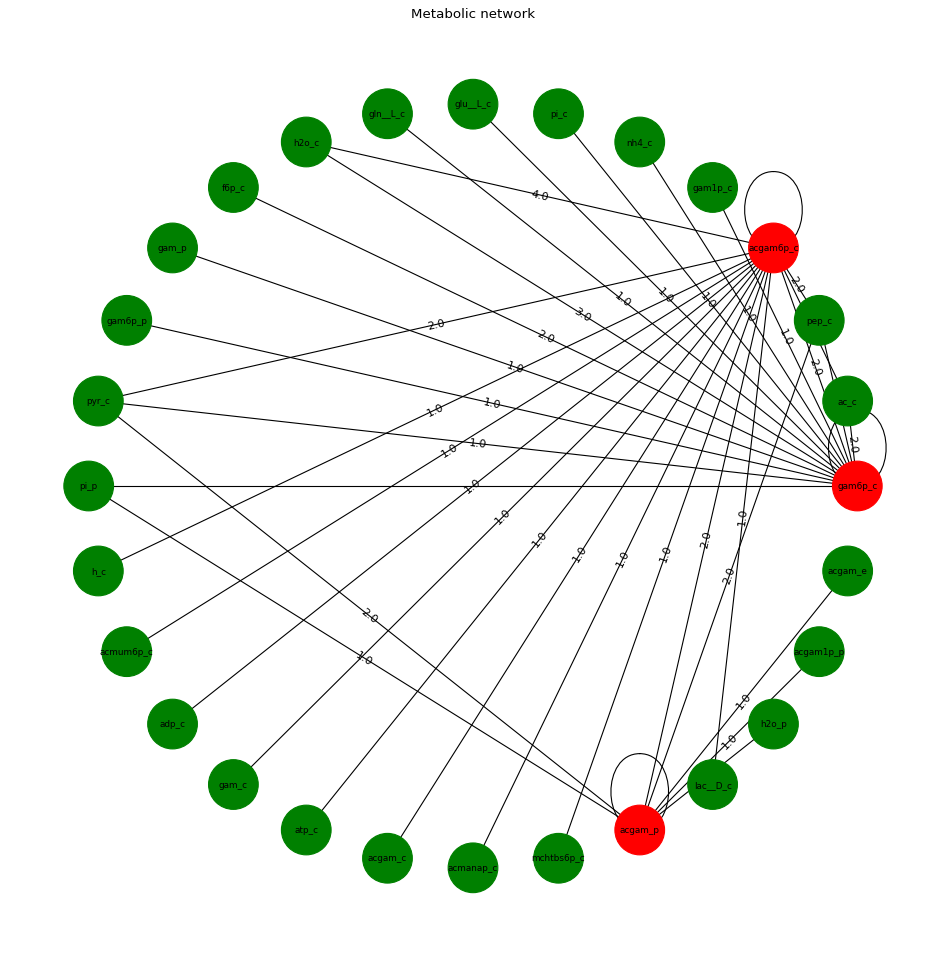

In [152]:
def check_neighbor_weights(g,nodes):
    subg=nx.Graph() #Create subgraph
    for n in nodes:
        subg.add_node(n)
        neighbors=g.neighbors(n) #Find all neighbors of node n
        for neighs in neighbors:
            if g[n][neighs]['weight']<50: #Check if the weigh t is below 50
                subg.add_edge(n,neighs,weight=g[n][neighs]['weight'])
    return subg

subg=check_neighbor_weights(compound_centric_network,[gam6p_c, acgam6p_c, acgam_p]) #Returns subgraph of interest

color_map = []
for node in subg.nodes():
    if node in [gam6p_c, acgam6p_c, acgam_p]:
        color_map.append('red')
    else: 
        color_map.append('green')      


plt.figure(figsize=(15, 15), dpi=80)
plt.title('Metabolic network')
labels_subg = nx.get_edge_attributes(subg,'weight')
pos_subg=nx.circular_layout(subg)
nx.draw_networkx_edge_labels(subg,pos=pos_subg,edge_labels=labels_subg)
nx.draw(subg,pos=pos_subg,with_labels=True,node_color=color_map,node_size=2000,font_size=8)

plt.show()

# OptGene

In [18]:
from cameo.strain_design.heuristic.evolutionary_based import OptGene

In [19]:
optgene = OptGene(model)

In [20]:
result = optgene.run(target=model.reactions.ExRe2, 
                     biomass=model.reactions.BIOMASS_Ec_iML1515_core_75p37M,
                     substrate=model.metabolites.glc__D_e,
                     max_evaluations=20000, population_size=200, max_knockouts=5,
                     plot=False, growth_coupled=True)

Starting optimization at Tue, 22 Nov 2022 16:16:44


HBox()

Finished after 09:30:23


In [21]:
result

No solutions found


IndexError: index 0 is out of bounds for axis 0 with size 0

# dFBA

In [177]:
from dfba import DfbaModel, ExchangeFlux, KineticVariable

model = read_sbml_model('iML1515.xml')

ModuleNotFoundError: No module named 'dfba'

In [3]:
# media
medium = model.medium
medium['EX_glc__D_e'] = 30
medium['EX_rib__D_e'] = 10
model.medium = medium

model.genes.get_by_id("b0677").knock_out()
model.genes.get_by_id("b0678").knock_out()
model.genes.get_by_id("b0679").knock_out()
model.genes.get_by_id("b1817").knock_out()
model.genes.get_by_id("b1818").knock_out()
model.genes.get_by_id("b1819").knock_out()
model.genes.get_by_id("b1101").knock_out()
model.genes.get_by_id("b2415").knock_out()
model.genes.get_by_id("b2416").knock_out()
model.genes.get_by_id("b2417").knock_out()

#gene integration
reaction = Reaction("ExRe1")
reaction.name = "GlcNAc-6-P N-Acetyltransferase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("ac_c"): -1.0,
    model.metabolites.get_by_id("gam6p_c"): -1.0,
    model.metabolites.get_by_id("acgam6p_c"): 1.0,
    model.metabolites.get_by_id("h2o_c"): 1.0
})
model.add_reactions([reaction])
reaction = Reaction("ExRe2")
reaction.name = "GlcNAc-6-P phosphatase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("acgam6p_c"): -1.0,
    model.metabolites.get_by_id("pyr_c"): -1.0,
    model.metabolites.get_by_id("pep_c"): 1.0,
    model.metabolites.get_by_id("acgam_p"): 1.0
})
model.add_reactions([reaction])

model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.7
model.objective = model.reactions.ExRe2

In [4]:
model.solver = "glpk"
dfba_model = DfbaModel(model)

In [5]:
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Rib = KineticVariable("Ribose")
Oxy = KineticVariable("Oxygen")
Gluc_amine = KineticVariable("Glucosamine")

dfba_model.add_kinetic_variables([X, Gluc, Rib, Oxy, Gluc_amine])

In [6]:
mu = ExchangeFlux("BIOMASS_Ec_iML1515_core_75p37M")
v_G = ExchangeFlux("EX_glc__D_e")
v_R = ExchangeFlux("EX_rib__D_e")
v_O = ExchangeFlux("EX_o2_e")
v_GS = ExchangeFlux("EX_acgam_e")

dfba_model.add_exchange_fluxes([mu, v_G, v_R, v_O, v_GS])

In [10]:
dfba_model.add_rhs_expression("Biomass", mu * X - 0.461 * X)
# dfba_model.add_rhs_expression("Glucose", v_G * 180.1559/1000 * X) # v_G [mmol gDW^-1 h^-1] * 0.18 g/mmol * gDW/L
# dfba_model.add_rhs_expression("Ribose", v_R * 150.13/1000 * X)
dfba_model.add_rhs_expression("Glucose", 0) # v_G [mmol gDW^-1 h^-1] * 0.18 g/mmol * gDW/L
dfba_model.add_rhs_expression("Ribose", 0)
dfba_model.add_rhs_expression("Oxygen", 0) # O2 is kept constant
dfba_model.add_rhs_expression("Glucosamine", v_GS * 221.2078/1000 * X)

In [11]:
vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)


vmax_glc = 10.5 # [mmol gDW^-1 h^-1]
Kg = 0.0027 # g/L Glucose Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb(
    "EX_glc__D_e",
    vmax_glc * (Gluc / (Kg + Gluc)),
    Gluc
)

vmax_rib = 6 # [mmol gDW^-1 h^-1]
Kr = 0.0165
dfba_model.add_exchange_flux_lb(
    "EX_rib__D_e",
    vmax_rib 
    * (Rib / (Kr + Rib)),
    Rib,
)

dfba_model.add_exchange_flux_lb(
    "BIOMASS_Ec_iML1515_core_75p37M",
    0.45 * (X / (0.1 + X)),
    X,
)


In [12]:
dfba_model.add_initial_conditions(
    {
        "Biomass": 0.01, # (gDW/L)
        "Glucose": 30, # (g/L)
        "Ribose": 10.0,   # (g/L)
        "Oxygen": 0.5,  # (mmol/L)
        "Glucosamine": 0.0,  # (g/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 100.0, 0.1, ["EX_glc__D_e", "EX_rib__D_e", "EX_acgam_e", "BIOMASS_Ec_iML1515_core_75p37M"])

cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++




Final Run Statistics: 

Number of steps                    = 0
Number of residual evaluations     = 0
Number of Jacobian evaluations     = 20
Number of nonlinear iterations     = 0
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 0

Total simulation time was 4.16797 seconds



In [13]:
concentrations

time   Biomass  Glucosamine  Glucose  Oxygen  Ribose
0       0.0  0.010000     0.000000     30.0     0.5    10.0
1       0.1  0.010200     0.037204     30.0     0.5    10.0
2       0.2  0.010403     0.075153     30.0     0.5    10.0
3       0.3  0.010609     0.113864     30.0     0.5    10.0
4       0.4  0.010818     0.153339     30.0     0.5    10.0
...     ...       ...          ...      ...     ...     ...
996    99.6  0.113254   355.282977     30.0     0.5    10.0
997    99.7  0.113254   355.700350     30.0     0.5    10.0
998    99.8  0.113254   356.117723     30.0     0.5    10.0
999    99.9  0.113254   356.535096     30.0     0.5    10.0
1000  100.0  0.113255   356.952469     30.0     0.5    10.0

[1001 rows x 6 columns]

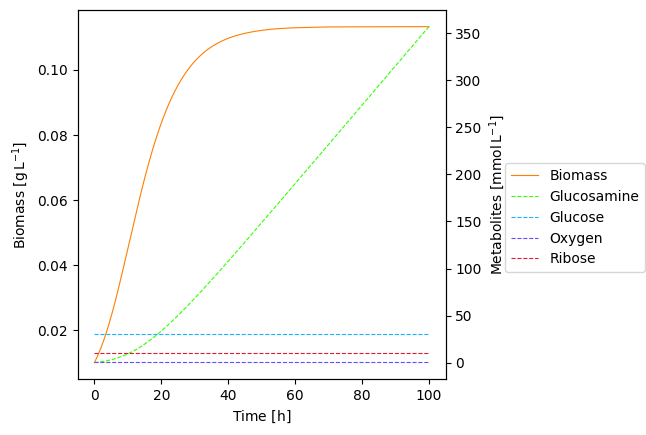

In [14]:
from dfba.plot.matplotlib import *
plot_concentrations(concentrations)

In [15]:
trajectories

time  EX_glc__D_e  EX_rib__D_e  EX_acgam_e  \
0       0.0     0.000000     0.000000    0.000000   
1       0.1   -10.499055    -5.990116  166.527689   
2       0.2   -10.499055    -5.990116  166.527954   
3       0.3   -10.499055    -5.990116  166.528222   
4       0.4   -10.499055    -5.990116  166.528493   
...     ...          ...          ...         ...   
996    99.6   -10.499055    -5.990116  166.597336   
997    99.7   -10.499055    -5.990116  166.597336   
998    99.8   -10.499055    -5.990116  166.597336   
999    99.9   -10.499055    -5.990116  166.597336   
1000  100.0   -10.499055    -5.990116  166.597336   

      BIOMASS_Ec_iML1515_core_75p37M  
0                           0.000000  
1                           0.658350  
2                           0.657599  
3                           0.656839  
4                           0.656071  
...                              ...  
996                         0.461016  
997                         0.461016  
998                         0.461016  
999                         0.461015  
1000                        0.461015  

[1001 rows x 5 columns]

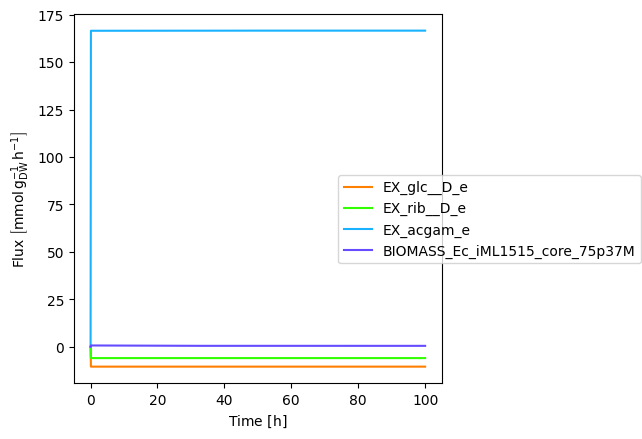

In [16]:
plot_trajectories(trajectories)

# FSEOF

In [180]:
model = read_sbml_model('iML1515.xml')

In [181]:
# media
medium = model.medium
medium['EX_glc__D_e'] = 30
medium['EX_rib__D_e'] = 10
model.medium = medium

model.genes.get_by_id("b0677").knock_out()
model.genes.get_by_id("b0678").knock_out()
model.genes.get_by_id("b0679").knock_out()
model.genes.get_by_id("b1817").knock_out()
model.genes.get_by_id("b1818").knock_out()
model.genes.get_by_id("b1819").knock_out()
model.genes.get_by_id("b1101").knock_out()
model.genes.get_by_id("b2415").knock_out()
model.genes.get_by_id("b2416").knock_out()
model.genes.get_by_id("b2417").knock_out()

#gene integration
reaction = Reaction("ExRe1")
reaction.name = "GlcNAc-6-P N-Acetyltransferase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("ac_c"): -1.0,
    model.metabolites.get_by_id("gam6p_c"): -1.0,
    model.metabolites.get_by_id("acgam6p_c"): 1.0,
    model.metabolites.get_by_id("h2o_c"): 1.0
})
model.add_reactions([reaction])
reaction = Reaction("ExRe2")
reaction.name = "GlcNAc-6-P phosphatase"
reaction.lower_bound = 0
reaction.upper_bound = 1000

reaction.add_metabolites({
    model.metabolites.get_by_id("acgam6p_c"): -1.0,
    model.metabolites.get_by_id("pyr_c"): -1.0,
    model.metabolites.get_by_id("pep_c"): 1.0,
    model.metabolites.get_by_id("acgam_p"): 1.0
})
model.add_reactions([reaction])

model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = 0.45

In [182]:
from cameo.strain_design.deterministic.flux_variability_based import FSEOF

In [183]:
fseof = FSEOF(model)

In [184]:
result = fseof.run(target=model.reactions.ExRe2)

In [185]:
result.data_frame 

1          2          3          4          5          6   \
PYK       42.528345  42.889236  43.250127  43.611018  43.971908  44.332799   
PFL        0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
PTAr       0.356230   2.673906   4.991583   7.309260   9.626937  11.944614   
ACKr      -0.356230  -2.673906  -4.991583  -7.309260  -9.626937 -11.944614   
PGI       21.187679  21.523510  21.859341  22.195172  22.531002  22.866833   
GART       0.007630   0.006995   0.006360   0.005725   0.005090   0.004455   
GF6PTA     2.460886   4.603432   6.745977   8.888523  11.031069  13.173614   
SPODM      0.012143   0.011132   0.010122   0.009111   0.008101   0.007091   
THD2pp     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
TKT2       4.472511   4.510203   4.547895   4.585587   4.623279   4.660972   
ASPO3      0.007085   0.006496   0.005906   0.005317   0.004727   0.004137   
ACGAtex   -2.167000  -4.334001  -6.501001  -8.668001 -10.835001 -13.002002   
PROt2rpp  -0.016189  -0.014842  -0.013495  -0.012148  -0.010801  -0.009454   
PROt4pp    0.016189   0.014842   0.013495   0.012148   0.010801   0.009454   
GLNS       7.039145   8.800728  10.562311  12.323893  14.085476  15.847059   
QMO2       0.012143   0.011132   0.010122   0.009111   0.008101   0.007091   
RPI        1.440508   1.742899   2.045290   2.347681   2.650071   2.952462   
ExRe1      2.167000   4.334001   6.501001   8.668001  10.835001  13.002002   
ExRe2      2.167000   4.334001   6.501001   8.668001  10.835001  13.002002   

                 7          8          9          10  
PYK       44.693690  45.054581  45.415472  47.793784  
PFL        0.000000   0.000000   0.000000   0.083719  
PTAr      14.262291  16.579968  18.897645  21.220442  
ACKr     -14.262291 -16.579968 -18.897645 -21.220442  
PGI       23.202664  23.538495  23.874326  29.890527  
GART       0.003820   0.003185   0.002551   0.085613  
GF6PTA    15.316160  17.458706  19.601251  21.742966  
SPODM      0.006080   0.005070   0.004059   0.003015  
THD2pp     0.000000   0.000000   0.000000   9.227326  
TKT2       4.698664   4.736356   4.774048   2.923369  
ASPO3      0.003548   0.002958   0.002369   0.001759  
ACGAtex  -15.169002 -17.336002 -19.503003 -21.670003  
PROt2rpp  -0.008106  -0.006759  -0.005412  -0.004019  
PROt4pp    0.008106   0.006759   0.005412   0.004019  
GLNS      17.608641  19.370224  21.131807  22.879611  
QMO2       0.006080   0.005070   0.004059   0.003015  
RPI        3.254853   3.557244   3.859635   6.061955  
ExRe1     15.169002  17.336002  19.503003  21.670003  
ExRe2     15.169002  17.336002  19.503003  21.670003

In [198]:
with model:
    #model.objective = "ExRe2"
    print(model.optimize().fluxes["ACKr"])

1.9614473752651846


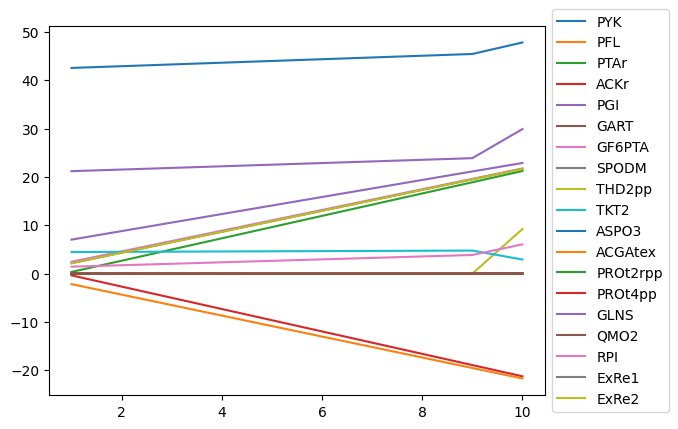

In [186]:
result.data_frame.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [200]:
res = result.data_frame

In [201]:
res["diff"] = abs(result.data_frame[:][10] - result.data_frame[:][1])

In [202]:
res = res.sort_values("diff", ascending=False)
res

1          2          3          4          5          6  \
PTAr       0.356230   2.673906   4.991583   7.309260   9.626937  11.944614   
ACKr      -0.356230  -2.673906  -4.991583  -7.309260  -9.626937 -11.944614   
ACGAtex   -2.167000  -4.334001  -6.501001  -8.668001 -10.835001 -13.002002   
ExRe1      2.167000   4.334001   6.501001   8.668001  10.835001  13.002002   
ExRe2      2.167000   4.334001   6.501001   8.668001  10.835001  13.002002   
GF6PTA     2.460886   4.603432   6.745977   8.888523  11.031069  13.173614   
GLNS       7.039145   8.800728  10.562311  12.323893  14.085476  15.847059   
THD2pp     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
PGI       21.187679  21.523510  21.859341  22.195172  22.531002  22.866833   
PYK       42.528345  42.889236  43.250127  43.611018  43.971908  44.332799   
RPI        1.440508   1.742899   2.045290   2.347681   2.650071   2.952462   
TKT2       4.472511   4.510203   4.547895   4.585587   4.623279   4.660972   
PFL        0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
GART       0.007630   0.006995   0.006360   0.005725   0.005090   0.004455   
PROt2rpp  -0.016189  -0.014842  -0.013495  -0.012148  -0.010801  -0.009454   
PROt4pp    0.016189   0.014842   0.013495   0.012148   0.010801   0.009454   
SPODM      0.012143   0.011132   0.010122   0.009111   0.008101   0.007091   
QMO2       0.012143   0.011132   0.010122   0.009111   0.008101   0.007091   
ASPO3      0.007085   0.006496   0.005906   0.005317   0.004727   0.004137   

                  7          8          9         10       diff  
PTAr      14.262291  16.579968  18.897645  21.220442  20.864212  
ACKr     -14.262291 -16.579968 -18.897645 -21.220442  20.864212  
ACGAtex  -15.169002 -17.336002 -19.503003 -21.670003  19.503003  
ExRe1     15.169002  17.336002  19.503003  21.670003  19.503003  
ExRe2     15.169002  17.336002  19.503003  21.670003  19.503003  
GF6PTA    15.316160  17.458706  19.601251  21.742966  19.282080  
GLNS      17.608641  19.370224  21.131807  22.879611  15.840466  
THD2pp     0.000000   0.000000   0.000000   9.227326   9.227326  
PGI       23.202664  23.538495  23.874326  29.890527   8.702848  
PYK       44.693690  45.054581  45.415472  47.793784   5.265439  
RPI        3.254853   3.557244   3.859635   6.061955   4.621447  
TKT2       4.698664   4.736356   4.774048   2.923369   1.549142  
PFL        0.000000   0.000000   0.000000   0.083719   0.083719  
GART       0.003820   0.003185   0.002551   0.085613   0.077983  
PROt2rpp  -0.008106  -0.006759  -0.005412  -0.004019   0.012170  
PROt4pp    0.008106   0.006759   0.005412   0.004019   0.012170  
SPODM      0.006080   0.005070   0.004059   0.003015   0.009128  
QMO2       0.006080   0.005070   0.004059   0.003015   0.009128  
ASPO3      0.003548   0.002958   0.002369   0.001759   0.005326

In [203]:
res = res.iloc[:,:-1].head(10)
res

1          2          3          4          5          6  \
PTAr      0.356230   2.673906   4.991583   7.309260   9.626937  11.944614   
ACKr     -0.356230  -2.673906  -4.991583  -7.309260  -9.626937 -11.944614   
ACGAtex  -2.167000  -4.334001  -6.501001  -8.668001 -10.835001 -13.002002   
ExRe1     2.167000   4.334001   6.501001   8.668001  10.835001  13.002002   
ExRe2     2.167000   4.334001   6.501001   8.668001  10.835001  13.002002   
GF6PTA    2.460886   4.603432   6.745977   8.888523  11.031069  13.173614   
GLNS      7.039145   8.800728  10.562311  12.323893  14.085476  15.847059   
THD2pp    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
PGI      21.187679  21.523510  21.859341  22.195172  22.531002  22.866833   
PYK      42.528345  42.889236  43.250127  43.611018  43.971908  44.332799   

                 7          8          9         10  
PTAr     14.262291  16.579968  18.897645  21.220442  
ACKr    -14.262291 -16.579968 -18.897645 -21.220442  
ACGAtex -15.169002 -17.336002 -19.503003 -21.670003  
ExRe1    15.169002  17.336002  19.503003  21.670003  
ExRe2    15.169002  17.336002  19.503003  21.670003  
GF6PTA   15.316160  17.458706  19.601251  21.742966  
GLNS     17.608641  19.370224  21.131807  22.879611  
THD2pp    0.000000   0.000000   0.000000   9.227326  
PGI      23.202664  23.538495  23.874326  29.890527  
PYK      44.693690  45.054581  45.415472  47.793784

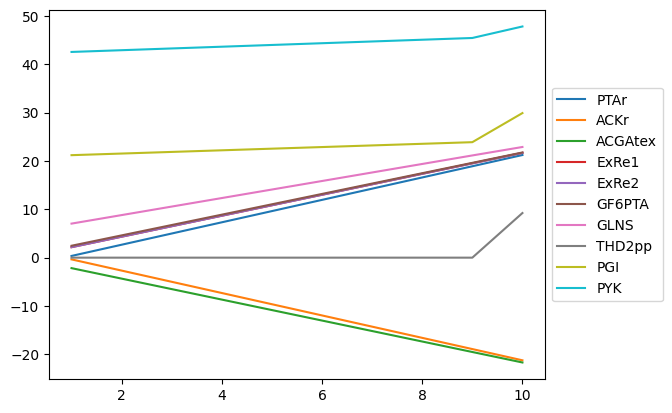

In [204]:
res.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [205]:
model.reactions.PYK #forward

<Reaction PYK at 0x1baec564310>

In [206]:
model.reactions.ACKr #reverse

<Reaction ACKr at 0x1baebe366a0>

# MEMOTE

In [2]:
from cobra.io import write_sbml_model
write_sbml_model(model, "iML1515_modified.xml")

In [3]:
%%time
!memote report snapshot iML1515.xml --filename iML1515.html

Scaling...Wall time: 5min 27s


Writing snapshot report to 'iML1515.html'.



 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
============================= test session starts =============================
platform win32 -- Python 3.8.13, pytest-4.6.11, py-1.11.0, pluggy-1.0.0
rootdir: C:\Users\HoangPham\Documents\GitHub\27410-group-assigment-group-13-glucosamine-in-e-coli\models
plugins: anyio-3.6.1
collected 155 items / 1 skipped / 154 selected

test_annotation.py ...FFFFFFFFF.FFFFF.FFFFFFFFFFFFFFF..FF..F...F....FFF. [ 34%]
F..FF.FFF...                                                             [ 41%]
test_basic.py ......F............F.FF                                    [ 56%]
test_biomass.py ...F...F.....FF..FF                                      [ 69%]
test_consistency.py ...ssssssssssssssss.FFFFF.FFF                        [ 87%]
test_essentiality.py s                                                   [ 88%]
test_growth.py s                                                         [ 89%]
test_mat

In [4]:
%%time
!memote report snapshot iML1515_modified.xml --filename iML1515_modified.html

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
============================= test session starts =============================
platform win32 -- Python 3.8.13, pytest-4.6.11, py-1.11.0, pluggy-1.0.0
rootdir: C:\Users\HoangPham\Documents\GitHub\27410-group-assigment-group-13-glucosamine-in-e-coli\models
plugins: anyio-3.6.1
collected 155 items / 1 skipped / 154 selected

test_annotation.py ...FFFFFFFFF.FFFFF.FFFFFFFFFFFFFFF..FF..F...F....FFF. [ 34%]
F..FF.FFF...                                                             [ 41%]
test_basic.py ......F............F.FF                                    [ 56%]
test_biomass.py ...F...F.....FF..FF                                      [ 69%]
test_consistency.py ...ssssssssssssssss.FFFFF.FFF                        [ 87%]
test_essentiality.py s                                                   [ 88%]
test_growth.py s                                                         [ 89%

Writing snapshot report to 'iML1515_modified.html'.


In [5]:
%%time
!memote report snapshot iJR904.xml --filename iJR904.html

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
============================= test session starts =============================
platform win32 -- Python 3.8.13, pytest-4.6.11, py-1.11.0, pluggy-1.0.0
rootdir: C:\Users\HoangPham\Documents\GitHub\27410-group-assigment-group-13-glucosamine-in-e-coli\models
plugins: anyio-3.6.1
collected 146 items / 1 skipped / 145 selected

test_annotation.py ...FFFFFFFF..FFFF..FFFFFFFFFFFFFFF..FF..F...F....FFF. [ 36%]
F..FF.FFF...                                                             [ 44%]
test_basic.py ......F............F.FF                                    [ 60%]
test_biomass.py .F.....F.F                                               [ 67%]
test_consistency.py ...ssssssssssssssssFFFFFF.FFF                        [ 86%]
test_essentiality.py s                                                   [ 87%]
test_growth.py s                                                         [ 88%

Writing snapshot report to 'iJR904.html'.


In [6]:
%%time
!memote report snapshot iAF1260.xml --filename iAF1260.html

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
============================= test session starts =============================
platform win32 -- Python 3.8.13, pytest-4.6.11, py-1.11.0, pluggy-1.0.0
rootdir: C:\Users\HoangPham\Documents\GitHub\27410-group-assigment-group-13-glucosamine-in-e-coli\models
plugins: anyio-3.6.1
collected 146 items / 1 skipped / 145 selected

test_annotation.py ...FFFFFFFF..FFFFF.FFFFFFFFFFFFFFF..FF..F...F....FFF. [ 36%]
F..FF.FFF...                                                             [ 44%]
test_basic.py ......F............F.FF                                    [ 60%]
test_biomass.py .F.....F.F                                               [ 67%]
test_consistency.py ...ssssssssssssssss..FFFF.FFF                        [ 86%]
test_essentiality.py s                                                   [ 87%]
test_growth.py s                                                         [ 88%

Writing snapshot report to 'iAF1260.html'.


In [7]:
%%time
!memote report snapshot iJO1366.xml --filename iJO1366.html

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
============================= test session starts =============================
platform win32 -- Python 3.8.13, pytest-4.6.11, py-1.11.0, pluggy-1.0.0
rootdir: C:\Users\HoangPham\Documents\GitHub\27410-group-assigment-group-13-glucosamine-in-e-coli\models
plugins: anyio-3.6.1
collected 155 items / 1 skipped / 154 selected

test_annotation.py ...FFFFFFFF..FFFFF.FFFFFFFFFFFFFFF..FF..F...F....FFF. [ 34%]
F..FF.FFF...                                                             [ 41%]
test_basic.py ......F............F.FF                                    [ 56%]
test_biomass.py .............FF..FF                                      [ 69%]
test_consistency.py ...ssssssssssssssss..FFFF.FFF                        [ 87%]
test_essentiality.py s                                                   [ 88%]
test_growth.py s                                                         [ 89%

Writing snapshot report to 'iJO1366.html'.
